### Load dataset

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/checkpoint-comments-labelled.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### TF-IDF + Logistic Regression

#### Step 1: Train-test split

In [ ]:
from sklearn.model_selection import train_test_split



RANDOM_STATE = 42
TEXT_COL = "cleanedCommentText"
TARGET_COL = "intent_label"

X = df[TEXT_COL].astype(str)
y = df[TARGET_COL].astype(str)

# train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

# val vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)


(69730, 14942, 14943)

#### Step 2: TF-IDF Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=20000,
    min_df=2,
    max_df=0.7
)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
X_test_vec  = vectorizer.transform(X_test)

X_train_vec.shape

(69730, 20000)

#### Step 3: Training classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced",
    C=2,
    penalty="l2",
    solver="liblinear",

)

clf.fit(X_train_vec, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


LogisticRegression(C=2, class_weight='balanced', max_iter=1000, n_jobs=-1,
                   solver='liblinear')

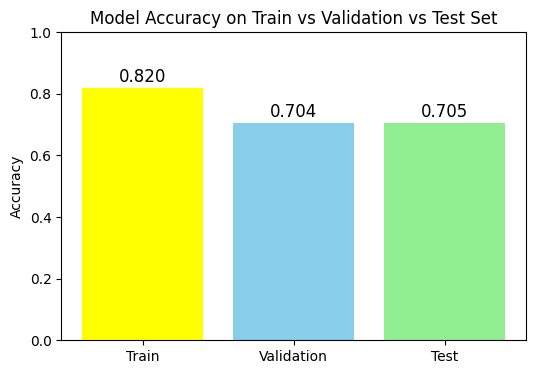

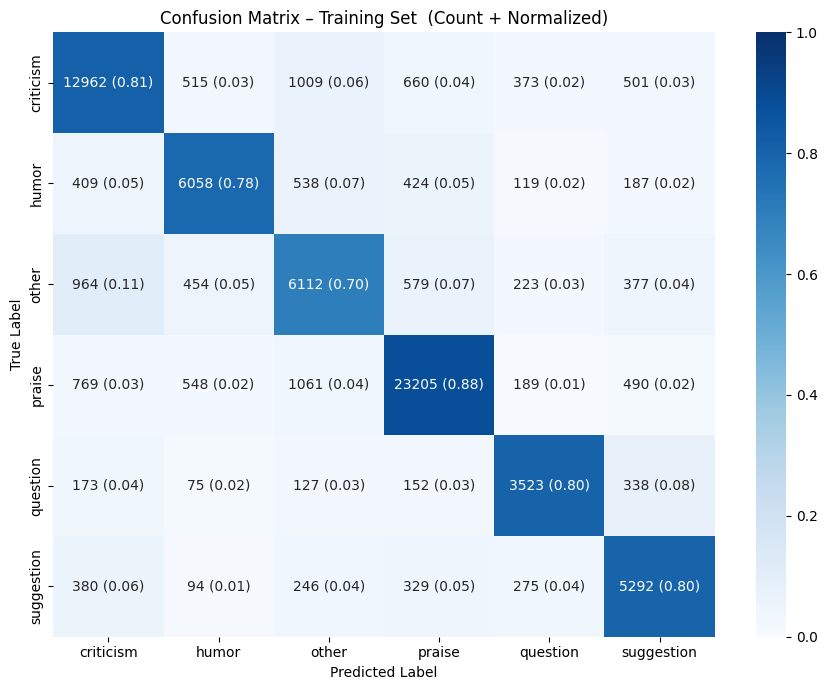

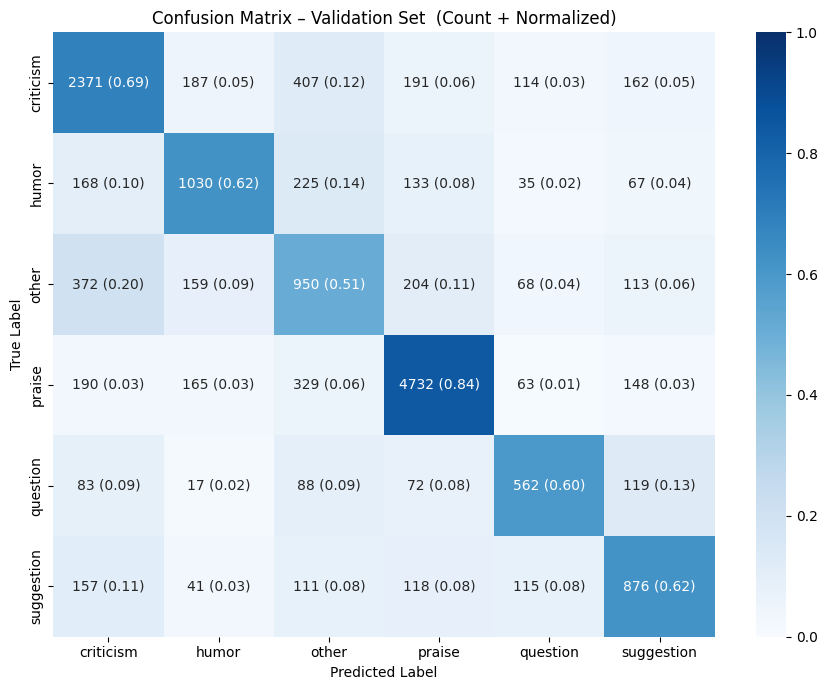

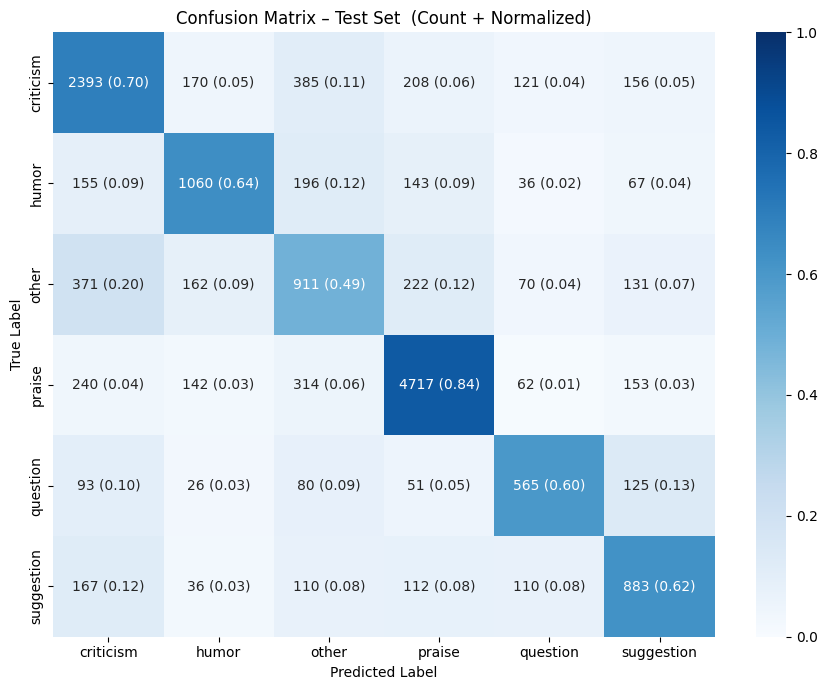

In [ ]:
y_test_pred = clf.predict(X_test_vec)
y_train_pred = clf.predict(X_train_vec)
y_val_pred = clf.predict(X_val_vec)


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

plt.figure(figsize=(6,4))
plt.bar(["Train", "Validation", "Test"], [train_acc, val_acc, test_acc], color=["yellow", "skyblue", "lightgreen"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy on Train vs Validation vs Test Set")
plt.ylim(0,1)

for i, v in enumerate([train_acc, val_acc, test_acc]):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=12)

plt.show()

import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, title):
    # Order classes consistently
    classes = sorted(list(set(y_true)))

    # Raw confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # Row-normalized confusion matrix
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)  # handle any division-by-zero rows

    # Text labels combining raw + normalized
    labels = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            labels[i, j] = f"{cm[i,j]} ({cm_norm[i,j]:.2f})"

    # Plot
    plt.figure(figsize=(9, 7))
    sns.heatmap(
        cm_norm,
        annot=labels,
        fmt="",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
        vmin=0.0,
        vmax=1.0,
        cbar=True
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title + "  (Count + Normalized)")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_train, y_train_pred, "Confusion Matrix – Training Set")
plot_confusion_matrix(y_val, y_val_pred, "Confusion Matrix – Validation Set")
plot_confusion_matrix(y_test, y_test_pred, "Confusion Matrix – Test Set")

#### Step 4: Hyper-parameter tuning (Grid Search)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=2000))
])


param_grid = {
    # TF-IDF options
    "tfidf__ngram_range": [(1,2)],      # unigrams + bigrams
    "tfidf__max_features": [15000, 20000, 30000],
    "tfidf__min_df": [2,3,4],
    "tfidf__max_df": [0.7, 0.6, 0.5],

    # Classifier
    "clf__C": [2, 3, 4],                      # regularization strength
    "clf__class_weight": ["balanced", None],    # compensate imbalance?
    "clf__penalty": ["l2"],                     # L1 possible too but slower
    "clf__solver": ["liblinear"],      # liblinear good for small ngrams
}


# use a subset for grid-search speed
train_subset = df.sample(10000, random_state=42)
X_train_sub = train_subset[TEXT_COL]
y_train_sub = train_subset[TARGET_COL]

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_sub, y_train_sub)

print("Best params:", grid.best_params_)
print("Best macro-F1:", grid.best_score_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best params: {'clf__C': 2, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__max_df': 0.7, 'tfidf__max_features': 20000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best macro-F1: 0.5704396431123029


### TF-IDF + Logistic Regression (using `Other` as fallback class)

#### Step 1: Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TEXT_COL = "cleanedCommentText"
TARGET_COL = "intent_label"

X = df[TEXT_COL].astype(str)
y = df[TARGET_COL].astype(str)

# train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# val vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)

original_x_train_len = len(X_train)
print("Original training set:", original_x_train_len)

# Remove "other" only from training set
train_mask = (y_train != "other")

X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]

print("Filtered training set:", len(X_train_filtered))
print("Removed:", original_x_train_len - len(y_train_filtered))


Original training set: 74711
Filtered training set: 65380
Removed: 9331


#### Step 2: TF-IDF Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=20000,
    min_df=2,
    max_df=0.25
)

X_train_filtered_vec = vectorizer.fit_transform(X_train_filtered)
X_train_vec = vectorizer.transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
X_test_vec  = vectorizer.transform(X_test)

X_train_vec.shape

(74711, 20000)

#### Step 3: Training classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    class_weight="balanced",
    C=2,
    penalty="l2",
    solver="liblinear",

)

clf.fit(X_train_filtered_vec, y_train_filtered)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


LogisticRegression(C=2, class_weight='balanced', max_iter=2000, n_jobs=-1,
                   solver='liblinear')

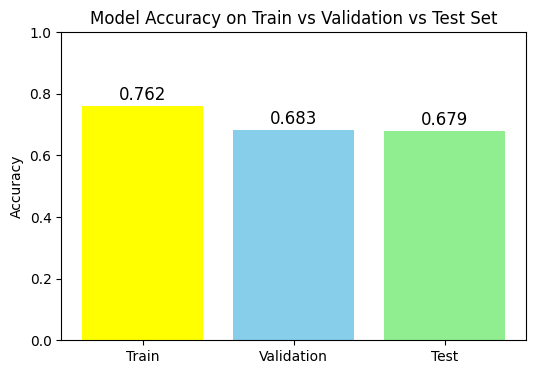

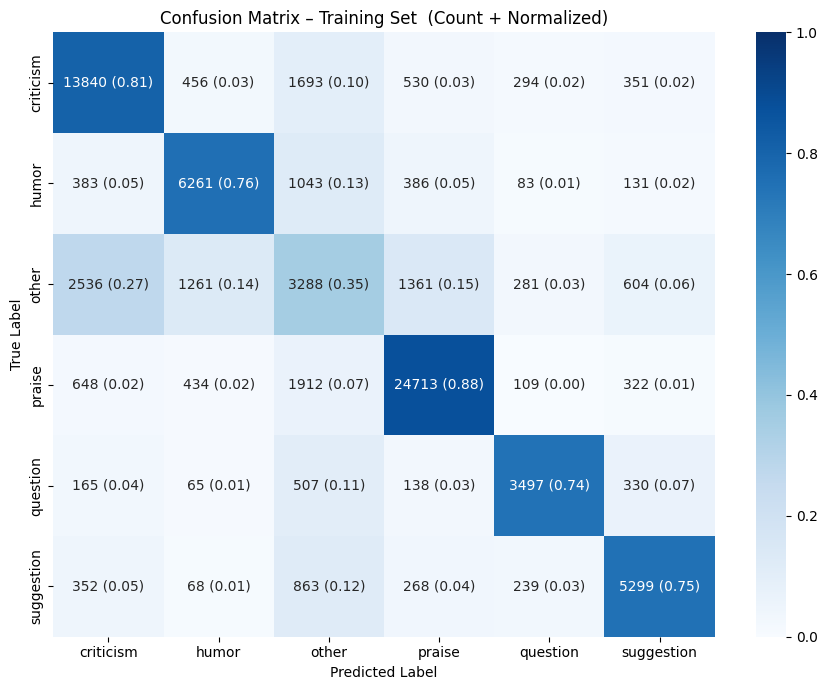

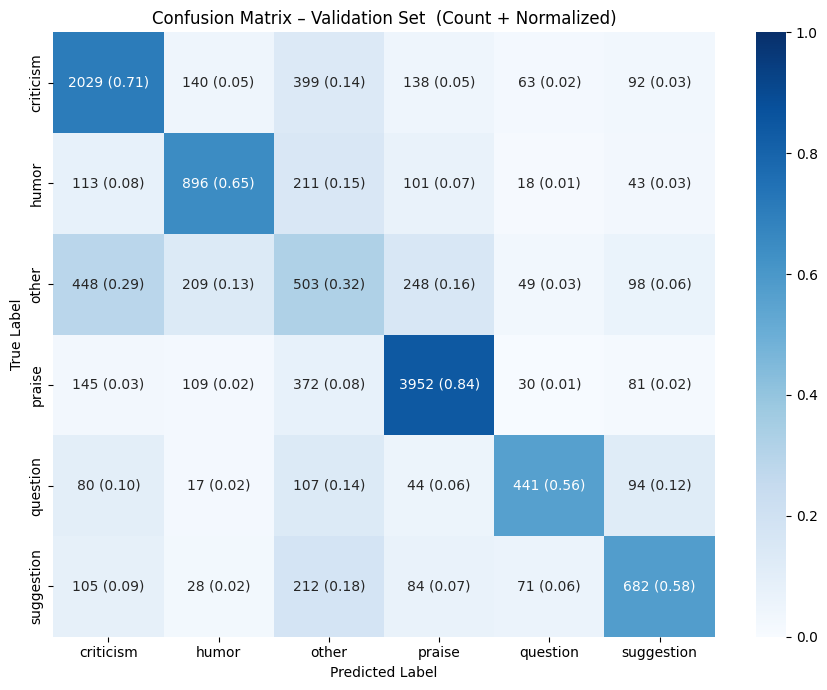

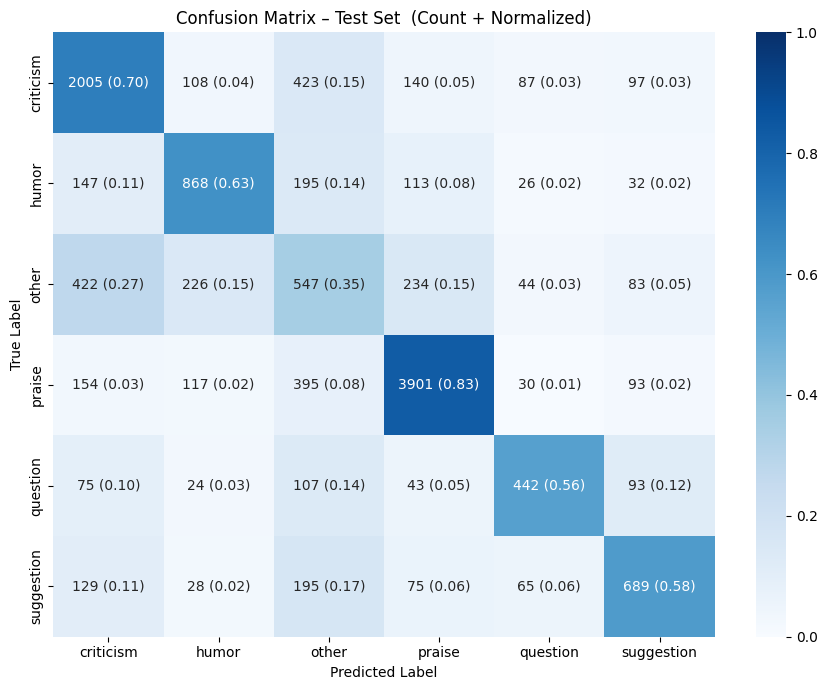

[[13840   456  1693   530   294   351]
 [  383  6261  1043   386    83   131]
 [ 2536  1261  3288  1361   281   604]
 [  648   434  1912 24713   109   322]
 [  165    65   507   138  3497   330]
 [  352    68   863   268   239  5299]]
[[2029  140  399  138   63   92]
 [ 113  896  211  101   18   43]
 [ 448  209  503  248   49   98]
 [ 145  109  372 3952   30   81]
 [  80   17  107   44  441   94]
 [ 105   28  212   84   71  682]]
[[2005  108  423  140   87   97]
 [ 147  868  195  113   26   32]
 [ 422  226  547  234   44   83]
 [ 154  117  395 3901   30   93]
 [  75   24  107   43  442   93]
 [ 129   28  195   75   65  689]]


In [ ]:
import numpy as np

THRESH = 0.45   # good starting point

def predict_with_fallback(clf, X_vec, threshold=THRESH):
    # probability estimates
    probs = clf.predict_proba(X_vec)

    # predicted classes
    preds = clf.classes_[np.argmax(probs, axis=1)]

    # max confidence per sample
    max_conf = probs.max(axis=1)

    # fallback to "other"
    preds[max_conf < threshold] = "other"

    return preds


y_train_pred = predict_with_fallback(clf, X_train_vec)
y_test_pred = predict_with_fallback(clf, X_test_vec)
y_val_pred = predict_with_fallback(clf, X_val_vec)


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

plt.figure(figsize=(6,4))
plt.bar(["Train", "Validation", "Test"], [train_acc, val_acc, test_acc], color=["yellow", "skyblue", "lightgreen"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy on Train vs Validation vs Test Set")
plt.ylim(0,1)

for i, v in enumerate([train_acc, val_acc, test_acc]):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=12)

plt.show()

import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, title):
    # Order classes consistently
    classes = sorted(list(set(y_true)))

    # Raw confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # Row-normalized confusion matrix
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)  # handle any division-by-zero rows

    # Text labels combining raw + normalized
    labels = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            labels[i, j] = f"{cm[i,j]} ({cm_norm[i,j]:.2f})"

    # Plot
    plt.figure(figsize=(9, 7))
    sns.heatmap(
        cm_norm,
        annot=labels,
        fmt="",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
        vmin=0.0,
        vmax=1.0,
        cbar=True
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title + "  (Count + Normalized)")
    plt.tight_layout()
    plt.show()

classes = sorted(list(set(y_test)))
plot_confusion_matrix(y_train, y_train_pred, "Confusion Matrix – Training Set")
plot_confusion_matrix(y_val, y_val_pred, "Confusion Matrix – Validation Set")
plot_confusion_matrix(y_test, y_test_pred, "Confusion Matrix – Test Set")

print(confusion_matrix(y_train, y_train_pred, labels=classes))
print(confusion_matrix(y_val, y_val_pred, labels=classes))
print(confusion_matrix(y_test, y_test_pred, labels=classes))


#### Step 4: Hyper-parameter tuning (Grid Search)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

df_gs = df[df.intent_label != "other"]

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=2000))
])


param_grid = {
    # TF-IDF options
    "tfidf__ngram_range": [(1,2)],      # unigrams + bigrams
    "tfidf__max_features": [20000],
    "tfidf__min_df": [2],
    "tfidf__max_df": [0.24, 0.25, 0.26],

    # Classifier
    "clf__C": [2],                      # regularization strength
    "clf__class_weight": ["balanced"],    # compensate imbalance?
    "clf__penalty": ["l2"],                     # L1 possible too but slower
    "clf__solver": ["liblinear"],      # liblinear good for small ngrams
}


# use a subset for grid-search speed
train_subset = df.sample(20000, random_state=42)
X_train_sub = train_subset[TEXT_COL]
y_train_sub = train_subset[TARGET_COL]

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_sub, y_train_sub)

print("Best params:", grid.best_params_)
print("Best macro-F1:", grid.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'clf__C': 2, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__max_df': 0.25, 'tfidf__max_features': 20000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best macro-F1: 0.5937942164809055
